# Parse documents with unstructured

In [1]:
import os
from dotenv import load_dotenv,find_dotenv
load_dotenv(find_dotenv(), override=True)

from unstructured_ingest.v2.pipeline.pipeline import Pipeline
from unstructured_ingest.v2.interfaces import ProcessorConfig

from unstructured_ingest.v2.processes.connectors.fsspec.gcs import (
    GcsIndexerConfig,
    GcsDownloaderConfig,
    GcsConnectionConfig,
    GcsAccessConfig
)

from unstructured_ingest.v2.processes.connectors.local import (
    LocalUploaderConfig
)
from unstructured_ingest.v2.processes.partitioner import PartitionerConfig
from unstructured_ingest.v2.processes.chunker import ChunkerConfig


In [2]:
local_file_input_dir = './data'
ds_store_path = os.path.join(local_file_input_dir, '.DS_Store')
if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
cloud_bucket_path='gs://processing-pdfs'
work_dir = './results'

In [3]:
Pipeline.from_configs(
    context=ProcessorConfig(disable_parallelism=True, work_dir=work_dir),
    indexer_config=GcsIndexerConfig(remote_url=cloud_bucket_path),
    downloader_config=GcsDownloaderConfig(download_dir=work_dir),
    source_connection_config=GcsConnectionConfig(
        access_config=GcsAccessConfig(
            service_account_key=os.getenv("GCS_SERVICE_ACCOUNT_KEY")
        )
    ),
    partitioner_config=PartitionerConfig(
        partition_by_api=True,
        api_key=os.getenv("UNSTRUCTURED_API_KEY"),
        partition_endpoint=os.getenv("UNSTRUCTURED_API_URL"),
        strategy="hi_res",
    ),
    chunker_config=ChunkerConfig(
        chunking_strategy="by_title",
        chunk_multipages=True,
        chunk_max_characters=4000,
        chunk_overlap=0,
    ),  
    uploader_config=LocalUploaderConfig(output_dir=work_dir)
).run()

2024-12-14 13:05:53,100 MainProcess INFO     created index with configs: {"remote_url": "gs://processing-pdfs", "protocol": "gs", "path_without_protocol": "processing-pdfs", "supported_protocols": ["s3", "s3a", "abfs", "az", "gs", "gcs", "box", "dropbox", "sftp"], "recursive": false, "sample_n_files": null}, connection configs: {"access_config": "**********", "connector_type": "gcs", "supported_protocols": ["gs", "gcs"]}
2024-12-14 13:05:53,101 MainProcess INFO     Created download with configs: {"download_dir": "results"}, connection configs: {"access_config": "**********", "connector_type": "gcs", "supported_protocols": ["gs", "gcs"]}
2024-12-14 13:05:53,101 MainProcess INFO     created partition with configs: {"strategy": "hi_res", "ocr_languages": null, "encoding": null, "additional_partition_args": null, "skip_infer_table_types": null, "fields_include": ["element_id", "text", "type", "metadata", "embeddings"], "flatten_metadata": false, "metadata_exclude": [], "element_exclude": [

# Get elements from chunking

https://docs.unstructured.io/api-reference/how-to/get-chunked-elements#ingest-python-library

In [4]:
import json, base64, zlib
from typing import List, Dict, Any

In [5]:
# Extract the contents of an orig_elements field.
def extract_orig_elements(orig_elements):
    decoded_orig_elements = base64.b64decode(orig_elements)
    decompressed_orig_elements = zlib.decompress(decoded_orig_elements)
    return decompressed_orig_elements.decode('utf-8')

def get_chunked_elements(input_json_file_path: str) -> List[Dict[str, Any]]:
    # Create a dictionary that will hold only
    # a transposed version of the returned elements. 
    # For instance, we just want to capture each element's ID,
    # the chunk's text, and the chunk's associated elements in context.
    orig_elements_dict: List[Dict[str, Any]] = []

    with open(input_json_file_path, 'r') as file:
        file_elements = json.load(file)

    for element in file_elements:
        # For each chunk that has an "orig_elements" field...
        if "orig_elements" in element["metadata"]:
            # ...get the chunk's associated elements in context...
            orig_elements = extract_orig_elements(element["metadata"]["orig_elements"])
            # ...and then transpose it and other associated fields into a separate dictionary.
            orig_elements_dict.append({
                "element_id": element["element_id"],
                "text": element["text"],
                "orig_elements": json.loads(orig_elements)
            })
    
    return orig_elements_dict


In [6]:
file="1999_cremers_reocr"

input_filepath = f"./results/{file}.pdf.json"
output_filepath = f"./results/{file}-elements-only.json"
pdf_path = f"./results/{file}.pdf"

orig_elements_dict = get_chunked_elements(input_json_file_path = input_filepath)

# Convert the elements into a JSON object.
orig_elements_json = json.dumps(orig_elements_dict, indent=2)

# Write the JSON to a file.
with open(output_filepath, "w") as file:
    file.write(orig_elements_json)

In [7]:
chunk=orig_elements_dict[0]
for element in chunk['orig_elements']:
    print(element['element_id'])
    print(element['metadata']['page_number'])
    print(element['metadata']['coordinates']['points'])

32d1350a332d94c06004af6b1d8a74fe
1
[[418.8, 175.8], [418.8, 263.8], [1285.8, 263.8], [1285.8, 175.8]]
43d921e54ac209d7c6882e9cfa5c463a
1
[[645.6, 301.4], [645.6, 324.9], [1054.4, 324.9], [1054.4, 301.4]]
fc2b23b56690ce72d4b98aa311b96a66
1
[[565.5, 333.3], [565.5, 356.7], [1138.6, 356.7], [1138.6, 333.3]]
9982c92396e7c02117a01189d14655c6
1
[[459.2, 363.5], [459.2, 421.8], [1238.9, 421.8], [1238.9, 363.5]]
6584df532a3cd4f949a1b255f5fcb151
1
[[414.4, 494.7], [414.4, 517.7], [565.9, 517.7], [565.9, 494.7]]
8536e878bbe7d5a7dbe2584d6d7d74ad
1
[[180.1, 555.7], [180.1, 706.0], [800.9, 706.0], [800.9, 555.7]]
2a20a1cf7395210b543280d8d39a0ece
1
[[177.6, 715.8], [177.6, 803.7], [805.5, 803.7], [805.5, 715.8]]
81fd3ec72f22b5f842d0178f98914639
1
[[174.4, 809.3], [174.4, 866.4], [807.2, 866.4], [807.2, 809.3]]
a47765a93cbfd327c669c9a9aad7ac76
1
[[897.9, 494.3], [897.9, 903.4], [1527.7, 903.4], [1527.7, 494.3]]
885788bd578cd7c1042eafc1ae8cf11f
1
[[364.0, 942.1], [364.0, 963.6], [616.2, 963.6], [616.2

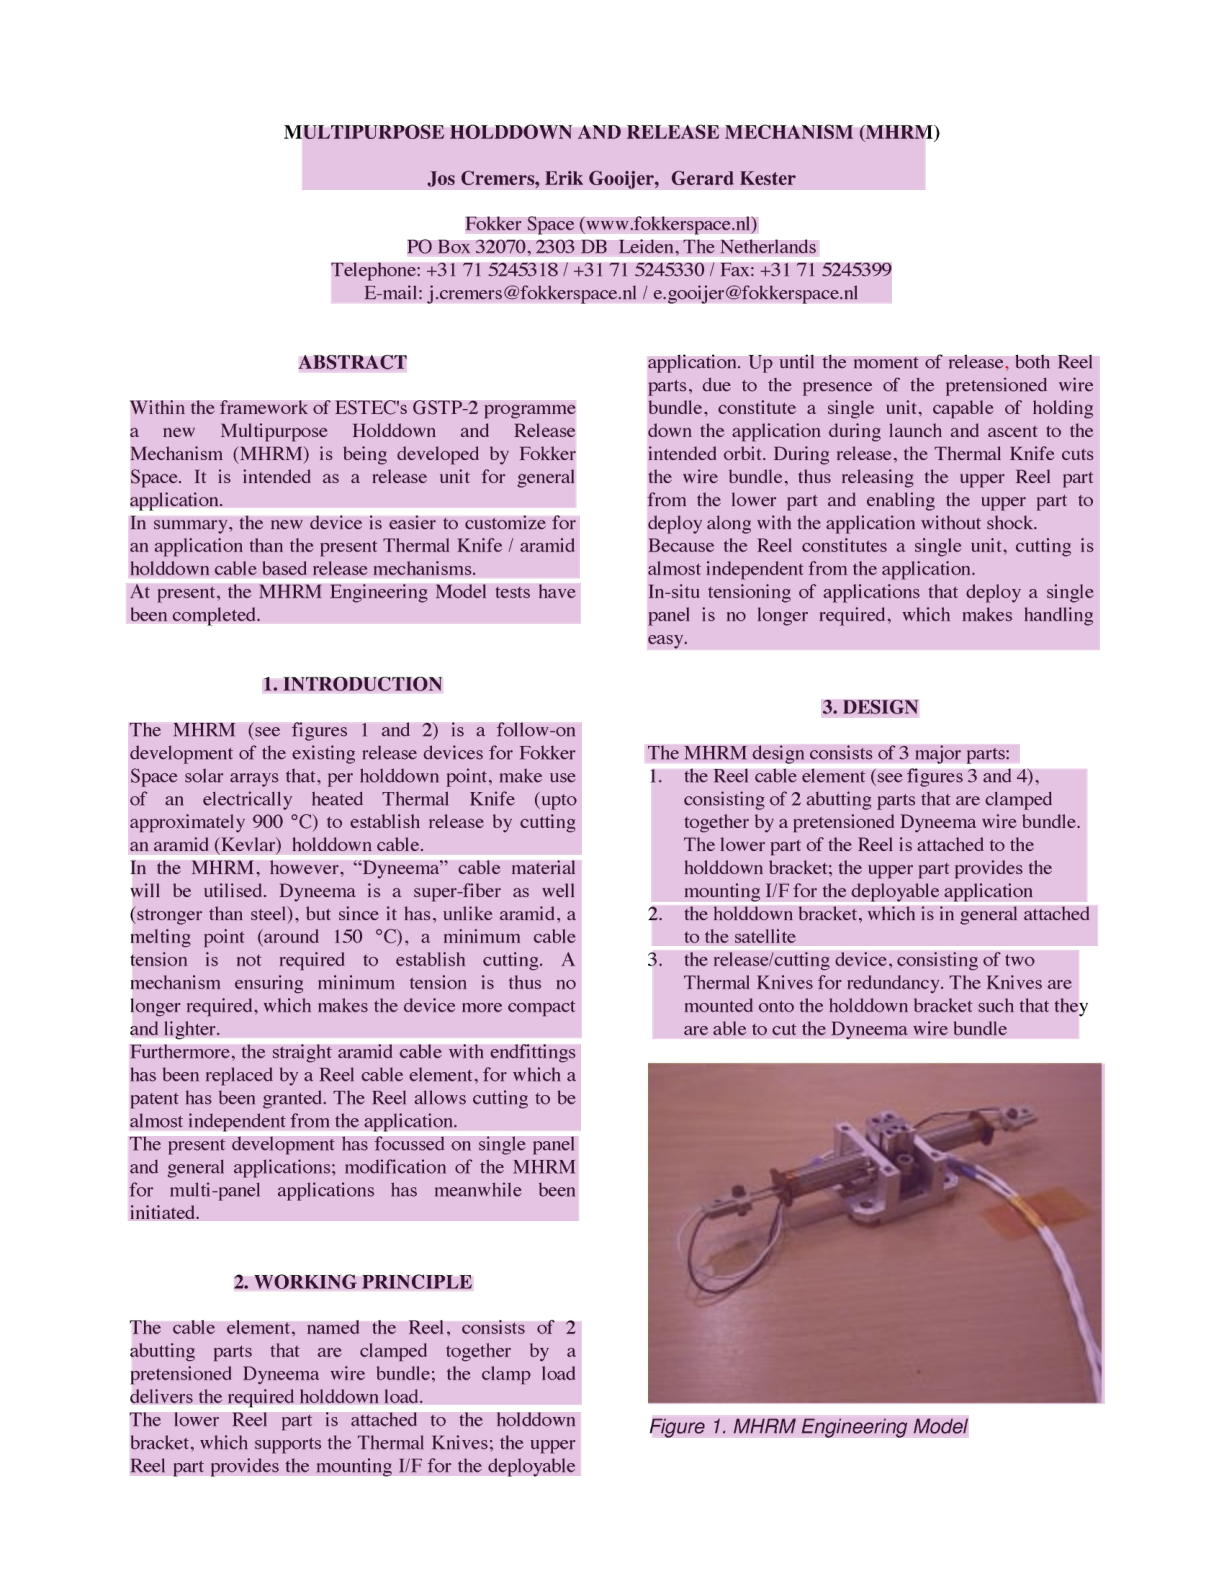

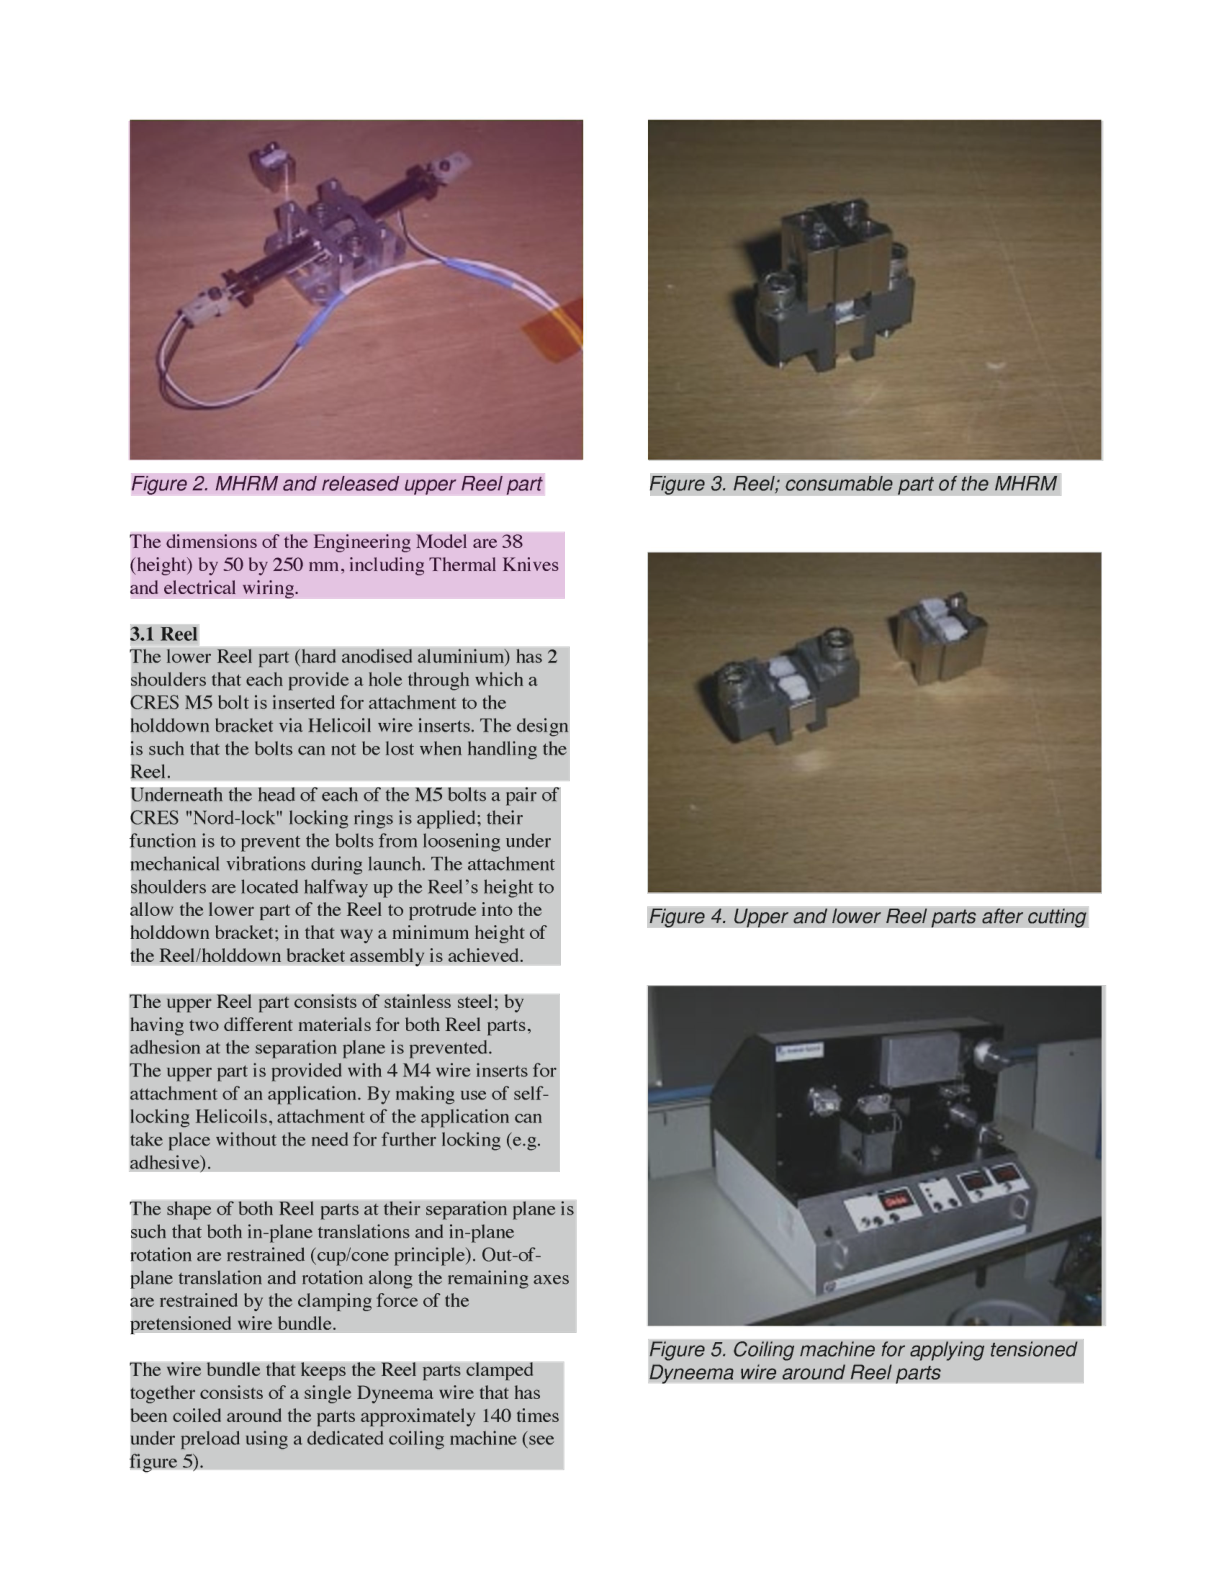

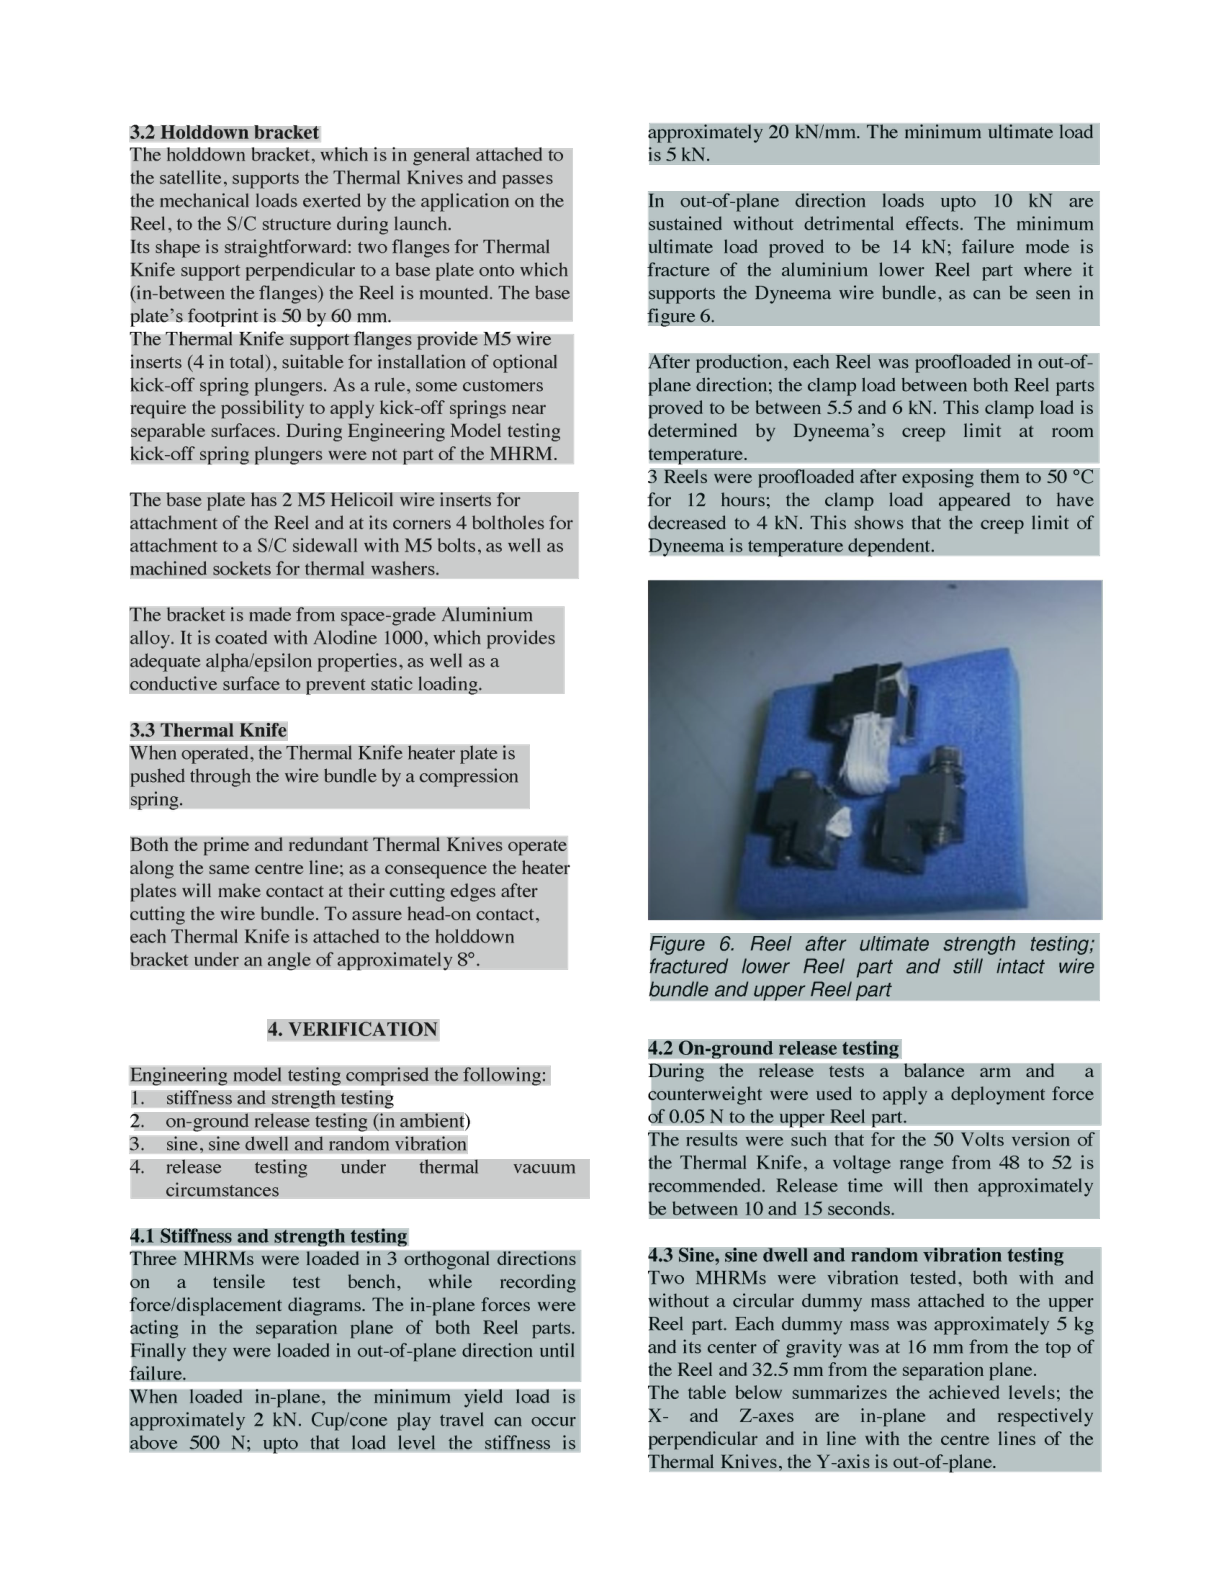

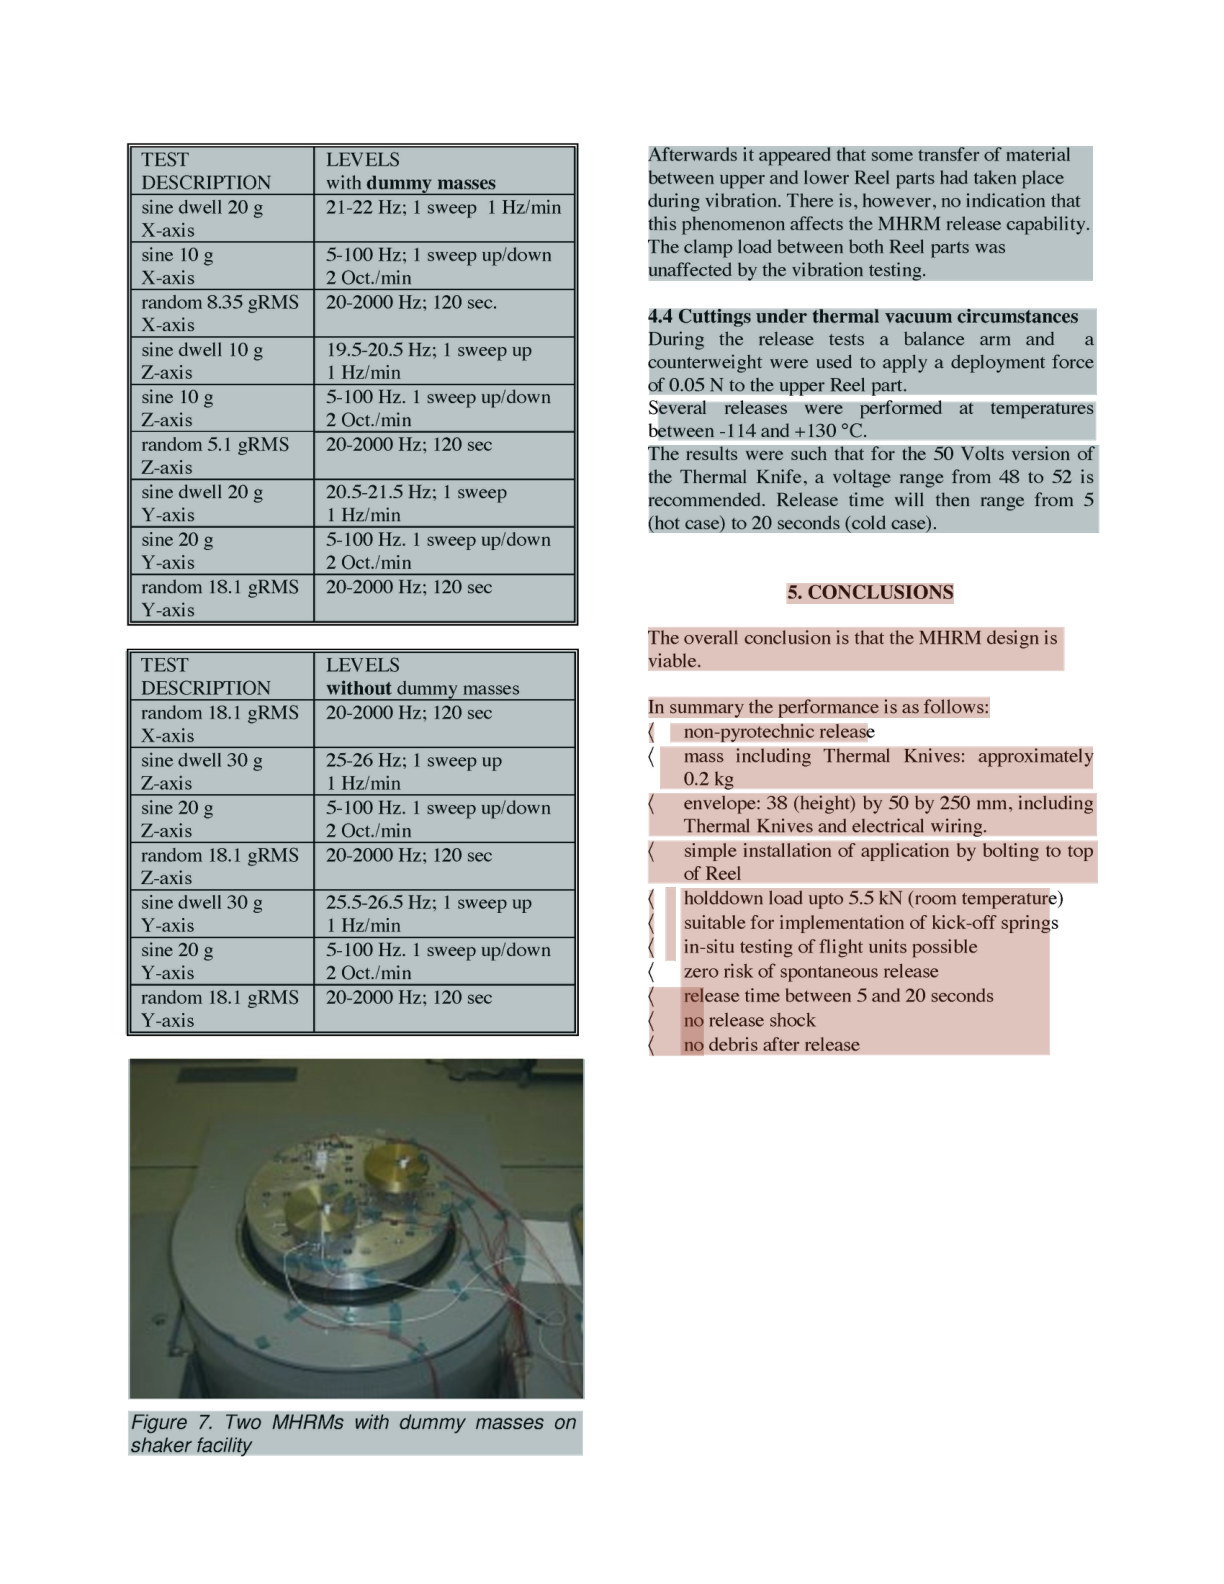

In [8]:
import fitz  # PyMuPDF
import json
from IPython.display import display, Image
from tempfile import NamedTemporaryFile
import random

# Load the PDF
doc = fitz.open(pdf_path)

# Get PDF dimensions
first_page = doc[0]
pdf_width = first_page.rect.width
pdf_height = first_page.rect.height

# Generate a list of random colors upfront (one for each chunk)
chunk_colors = [(random.uniform(0, 0.8), random.uniform(0, 0.8), random.uniform(0, 0.8)) 
                for _ in range(len(orig_elements_dict))]

# Process each chunk
for chunk_idx, chunk in enumerate(orig_elements_dict):
    # Use the same color for all elements in this chunk
    color = chunk_colors[chunk_idx]
    
    # Process each element in the chunk
    for element in chunk['orig_elements']:
        page_num = element['metadata']['page_number'] - 1
        page = doc[page_num]
        
        # Get pixel dimensions from the element's metadata
        pixel_width = element['metadata']['coordinates']['layout_width']
        pixel_height = element['metadata']['coordinates']['layout_height']
        
        # Calculate scale factors for both dimensions
        scale_x = pdf_width / pixel_width
        scale_y = pdf_height / pixel_height
        
        points = element['metadata']['coordinates']['points']
        
        # Scale the coordinates
        x0 = points[0][0] * scale_x
        y0 = points[0][1] * scale_y
        x2 = points[2][0] * scale_x
        y2 = points[2][1] * scale_y
        
        # Add rectangle annotation
        rect = page.add_rect_annot(fitz.Rect(x0, y0, x2, y2))
        rect.set_colors(stroke=color, fill=color)  # set both outline and fill color
        rect.set_opacity(0.3)  # make it semi-transparent
        rect.set_border(width=0.5)  # set border width
        rect.update()

# Display each page
for page in doc:
    pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # 2x zoom for better resolution
    with NamedTemporaryFile(suffix='.png') as tmp:
        pix.save(tmp.name)
        display(Image(filename=tmp.name))

doc.close()